In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
import itertools
from IPython import display
import time
import sys, os

In [2]:
batch_size = 100  # CIFAR10 total data = 50000
image_size = 64

batch shape =  torch.Size([100, 3, 64, 64])


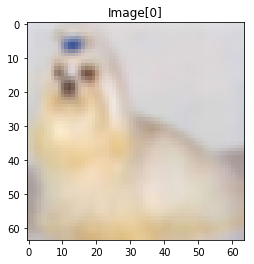

Label[0] =  dog
Image shape =  (100, 3, 64, 64)
Label shape =  (100,)


In [3]:
# Dataset
transform = transforms.Compose(  #list of transform object 
    [transforms.Resize(image_size), transforms.ToTensor(), # Resize 32 to 64
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# airplane[0], automobile[1], bird[2], cat[3], deer[4], dog[5], frog[6], horse[7], ship[8], truck[9]
train_dsets = dsets.CIFAR10('../data/cifar10/', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dsets, batch_size=batch_size, shuffle=True)

# train_loader data check
label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for n, (image, label) in enumerate(train_loader):
    if n == 0:
        print('batch shape = ', image.size())
        plt.imshow(np.transpose((image[0]+1)/2, (1,2,0))) # 3x64x64 to 64x64x3
        plt.title('Image[%d]' % n)
        plt.show()
        print('Label[%d] = ' % n, label_name[label[0]])
        print('Image shape = ', np.array(image).shape)
        print('Label shape = ', np.array(label).shape)
        break

In [4]:
# custom weights init
def weights_init(m):
    classname = type(m).__name__  # m.__class__.__name__ (old style)
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) # In Conv, mean=0, stdev=0.02
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # In BatchNorm, mean=1, stdev=0.02
        nn.init.constant_(m.bias.data, 0)

In [5]:
nc = 3  # n_channel, color = 3
ndf = 64  # number_discriminator_feature
ngf = 64  # number_generator_feature
nz = 100  # z latent vector, generator input size

In [6]:
# Model - Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input_size = ((batch)) * nc * 64 * 64
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            # size_out = {size_in + 2 * p - (dilation=1) * (k -1) -1} / s + 1
            #  32 = {64 + 2 * 1 - 1* (4 - 1) - 1} / 2 + 1
            nn.LeakyReLU(0.2, inplace=True),
            # state_size = ndf * 32 * 32
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features=ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state_size = (ndf*2) * 16 * 16
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state_size = (ndf*4) * 8 * 8
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state_size = (ndf*8) * 4 * 4
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, x):
        out = self.model(x)
        return out

In [7]:
# Model - Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input_size = ((batch)) * nz * 1 * 1
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
            # size_out = (size_in - 1) * s - 2 * p + k + (output_padding=0)
            #  4 = (1-1) * 1 - 2 * 0 + 4 + 0
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # state_size = (ngf*8) * 4 * 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state_size = (ngf*4) * 8 * 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state_size = (ngf*2) * 16 * 16
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state_size = (ngf) * 32 * 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh())
            # state_size = (nc) * 64 * 64
        
    def forward(self, x):
        out = self.model(x)
        return out

In [8]:
# Model to cuda
D = Discriminator().cuda()
G = Generator().cuda()

# Initalize custom weights
D.apply(weights_init)
G.apply(weights_init)

print(D)
print(G)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
Generator(
  (model): Sequential(
    (0): ConvTr

In [9]:
# Optimizer
beta1 = 0.5
lr = 0.0002
criterion = nn.BCELoss()
D_optimizer = Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
G_optimizer = Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
# Train - D
def D_train(D, real_image, real_label, fake_image, fake_label):
    D.zero_grad()
    output = D(real_image) # real_predict
    real_loss = criterion(output.view(-1), real_label)
    
    output = D(fake_image)
    fake_loss = criterion(output.view(-1), fake_label)
    
    D_loss = real_loss + fake_loss
    D_loss.backward()
    D_optimizer.step()
    return D_loss, real_loss, fake_loss

In [11]:
# Train - G
def G_train(G, fake_predict, real_label):
    G.zero_grad()
    G_loss = criterion(fake_predict.view(-1), real_label)
    G_loss.backward()
    G_optimizer.step()
    return G_loss

In [12]:
# Random noise for test
n_test = 16
test_noise = Variable(torch.randn(n_test, nz, 1, 1).cuda())

Epoch [1/20], D_loss = 0.313, G_loss = 4.186


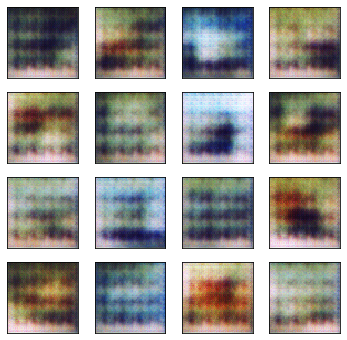

Epoch [10/20], D_loss = 1.657, G_loss = 0.713


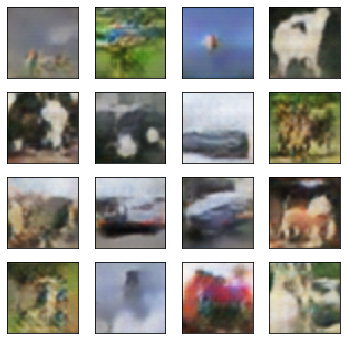

Epoch [20/20], D_loss = 0.680, G_loss = 1.965


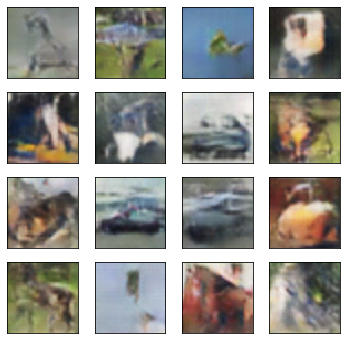

In [13]:
# image plot frame
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(6,6))
for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
# Train start
epochs = 20
G_loss_total = []
D_loss_total = []

start_time = time.time()

for epoch in range(epochs):
    for n, (real_image, _) in enumerate(train_loader):
        # real_image, real_label setting
        real_image = Variable(real_image.cuda())
        real_label = Variable(torch.ones(batch_size).cuda()) # real_label = 1
        
        # for Discriminator training
        noise = Variable(torch.randn(batch_size, nz, 1, 1).cuda())
        fake_image = G(noise)
        fake_label = Variable(torch.zeros(batch_size).cuda()) # fake_label = 0
        
        # Dicriminator training
        D_loss, real_loss, fake_loss = D_train(D, real_image,
                                              real_label, fake_image, fake_label)
        
        # for Generator training
        noise = Variable(torch.randn(batch_size, nz, 1, 1).cuda())
        fake_image = G(noise)
        fake_predict = D(fake_image)
        
        # Generator training
        G_loss = G_train(G, fake_predict, real_label)
        
        D_loss_total.append(D_loss.item())
        G_loss_total.append(G_loss.item())
        
    # test
    if epoch == 0 or (epoch+1) % 10 == 0:
        test_image = G(test_noise)
        for i in range(n_test):
            y = i // 4
            x = i % 4
            ax[x,y].cla()
            ax[x,y].imshow(np.transpose((test_image[i].data.cpu()+1)/2, (1,2,0)))
        plt.savefig('../save/cifar10/DCGAN_cifar10_%03d.png' % (epoch+1))
        print('Epoch [%d/%d], D_loss = %.3f, G_loss = %.3f' % (epoch+1, epochs, D_loss, G_loss))
        if epoch != epochs-1:
            display.display(plt.gcf())

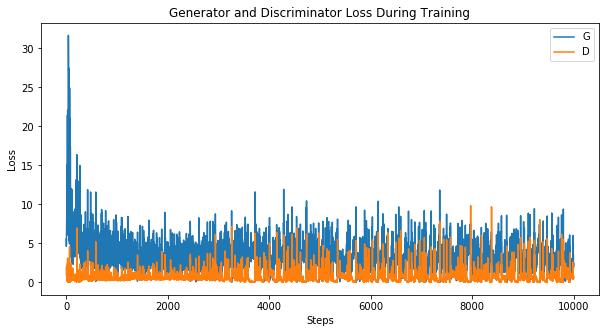

Elapsed Time = [2655.97]sec


In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss_total,label="G")
plt.plot(D_loss_total,label="D")
plt.xlabel("Steps") # Steps = 50000(dataset) / 100(batch) * 20(epoch) = 10000
plt.ylabel("Loss")
plt.legend()
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed Time = [%.2f]sec' % elapsed_time)

In [15]:
torch.save(Generator().state_dict(), '../save/cifar10/saved_generator.pt')

In [ ]:
# Reference code
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial
# https://github.com/prcastro/pytorch-gan/blob/master/MNIST%20GAN.ipynb